In [ ]:
from projection.registry import ProjectionRegistry
import numpy as np
# Create Mercator projection
mercator_proj = ProjectionRegistry.get_projection("mercator", R=6371, lat_min=-85, lat_max=85)

# Test forward projection
lon = np.array([-180, -90, 0, 90, 180])
lat = np.array([-85, -45, 0, 45, 85])
x, y = mercator_proj.create_projection().forward(lon, lat)
print(f"Forward: x={x}, y={y}")

# Test backward projection
lon_back, lat_back, mask = mercator_proj.create_projection().backward(x, y)
print(f"Backward: lon={lon_back}, lat={lat_back}, mask={mask}")

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import cv2
import numpy as np

def extend_equirectangular_with_fov(image, fov_extra):
    """
    Extends the height of an equirectangular image by computing h_prime based on FOV.

    Parameters:
        image (numpy.ndarray): The input equirectangular image (H x W x C).
        fov_extra (float): The additional FOV to add in degrees.

    Returns:
        numpy.ndarray: The extended image.
    """
    if fov_extra <= 0:
        raise ValueError("fov_extra must be a positive value.")
    
    # Get the original dimensions of the image
    height, width, channels = image.shape

    # Original vertical FOV for equirectangular images is 180°
    fov_original = 180.0

    # Calculate the additional height (h_prime) to extend
    h_prime = int((fov_extra / fov_original) * height)

    # Create a black region of the same width and the computed height
    black_extension = np.zeros((h_prime, width, channels), dtype=image.dtype)

    # Concatenate the original image with the black extension
    extended_image = np.vstack((image, black_extension))

    return extended_image, h_prime

# Example usage:
# Load an equirectangular image
image_path = "data/eq_sample.png"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Define the additional FOV in degrees
fov_extra = 30  # Add an additional 30° of vertical FOV

# Extend the image height based on the FOV
extended_image, h_prime = extend_equirectangular_with_fov(image, fov_extra)

# Save the extended image
#output_path = 'extended_equirectangular_image.jpg'
#cv2.imwrite(output_path, extended_image)

#print(f"Extended image saved to {output_path}. Added {h_prime} pixels for {fov_extra}° FOV.")

In [ ]:
import cv2
import numpy as np
import logging


class EquirectangularImage:
    @classmethod
    def extend_height(cls, image, fov_extra):
        """
        Extends the height of an equirectangular image based on the given additional FOV.
        """
        if not isinstance(image, np.ndarray):
            raise TypeError("Image must be a numpy array.")
        if fov_extra <= 0:
            return image  # No extension needed
        
        fov_original = 180.0
        height, width, channels = image.shape
        h_prime = int((fov_extra / fov_original) * height)
        black_extension = np.zeros((h_prime, width, channels), dtype=image.dtype)
        extended_image = np.vstack((image, black_extension))
        return extended_image

    @classmethod
    def rotate(cls, image, delta_lat, delta_lon):
        """
        Rotates an equirectangular image based on latitude and longitude shifts.
        """
        if image.ndim != 3 or image.shape[2] not in [1, 3, 4]:
            raise ValueError("Input image must be a 3D array with 1, 3, or 4 channels.")

        H, W, C = image.shape

        x = np.linspace(0, W - 1, W)
        y = np.linspace(0, H - 1, H)
        xv, yv = np.meshgrid(x, y)

        lon = (xv / (W - 1)) * 360.0 - 180.0
        lat = 90.0 - (yv / (H - 1)) * 180.0

        lat_rad = np.radians(lat)
        lon_rad = np.radians(lon)
        x_sphere = np.cos(lat_rad) * np.cos(lon_rad)
        y_sphere = np.cos(lat_rad) * np.sin(lon_rad)
        z_sphere = np.sin(lat_rad)

        delta_lat_rad = np.radians(delta_lat)
        delta_lon_rad = np.radians(delta_lon)

        x_rot = x_sphere
        y_rot = y_sphere * np.cos(delta_lat_rad) - z_sphere * np.sin(delta_lat_rad)
        z_rot = y_sphere * np.sin(delta_lat_rad) + z_sphere * np.cos(delta_lat_rad)

        x_final = x_rot * np.cos(delta_lon_rad) - y_rot * np.sin(delta_lon_rad)
        y_final = x_rot * np.sin(delta_lon_rad) + y_rot * np.cos(delta_lon_rad)
        z_final = z_rot

        lon_final = np.arctan2(y_final, x_final)
        lat_final = np.arcsin(z_final)

        lon_final_deg = np.degrees(lon_final)
        lat_final_deg = np.degrees(lat_final)

        x_rot_map = ((lon_final_deg + 180.0) / 360.0) * (W - 1)
        y_rot_map = ((90.0 - lat_final_deg) / 180.0) * (H - 1)

        map_x = x_rot_map.astype(np.float32)
        map_y = y_rot_map.astype(np.float32)

        rotated_image = cv2.remap(
            image,
            map_x,
            map_y,
            interpolation=cv2.INTER_LINEAR,
            borderMode=cv2.BORDER_WRAP
        )
        return rotated_image

    @classmethod
    def preprocess(cls, image, **kwargs):
        """
        Preprocess an equirectangular image by extending its height and then rotating it.

        Parameters:
            image (np.ndarray): Input equirectangular image.
            **kwargs: Parameters for preprocessing:
                - fov_extra (float): Additional field of view in degrees to extend. Default is 0.
                - delta_lat (float): Latitude rotation in degrees. Default is 0.
                - delta_lon (float): Longitude rotation in degrees. Default is 0.

        Returns:
            np.ndarray: Preprocessed image.
        """
        fov_extra = kwargs.get("fov_extra", 0)
        delta_lat = kwargs.get("delta_lat", 0)
        delta_lon = kwargs.get("delta_lon", 0)

        # Step 1: Extend the image height
        processed_image = cls.extend_height(image, fov_extra)

        # Step 2: Rotate the image
        processed_image = cls.rotate(processed_image, delta_lat, delta_lon)

        return processed_image

    @classmethod
    def save_image(cls, image, file_path):
        """
        Saves the current image to the specified file path.
        """
        if not isinstance(image, np.ndarray):
            raise TypeError("Image must be a numpy array.")
        cv2.imwrite(file_path, image)
        print(f"Image saved to {file_path}")


# Example Usage



input_image_path = "data/eq_sample.png"
image = cv2.imread(input_image_path)
if image is None:
    raise FileNotFoundError(f"Image not found at path: {input_image_path}")

# Define preprocessing parameters
kwargs = {
    "fov_extra": 30,  # Extend by 30° FOV
    "delta_lat": 90,  # Rotate 10° north
    "delta_lon": 0, # Rotate 98° west
}

# Preprocess the image
processed_image = EquirectangularImage.preprocess(image, **kwargs)

# Save the preprocessed image
EquirectangularImage.save_image(processed_image, "preprocessed_image.jpg")

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(processed_image)
plt.show()


In [ ]:
!pip install matplotlib

2025-01-13 16:40:14,250 - gnomonic_projection - INFO - Initializing Gnomonic Projection Package
2025-01-13 16:40:14,251 - gnomonic_projection.registry - INFO - Projection 'gnomonic' registered successfully.
2025-01-13 16:40:14,251 - gnomonic_projection.default_projections - INFO - Default projection 'gnomonic' registered successfully.
2025-01-13 16:40:14,252 - gnomonic_projection.registry - INFO - Projection 'mercator' registered successfully.
2025-01-13 16:40:14,252 - gnomonic_projection.default_projections - INFO - Default projection 'mercator' registered successfully.
2025-01-13 16:40:14,252 - gnomonic_projection - INFO - Default projections registered successfully.
2025-01-13 16:40:14,757 - gnomonic_projection.gnomonic.config - INFO - GnomonicConfig initialized successfully.
2025-01-13 16:40:14,757 - gnomonic_projection.gnomonic.strategy - INFO - GnomonicProjectionStrategy initialized successfully.
2025-01-13 16:40:14,758 - gnomonic_projection.base.interpolation - INFO - BaseInterp

/Users/robinsongarcia/projects/gnomonic/projection/gnomonic/strategy.py:65: RuntimeWarning: invalid value encountered in divide
  phi = np.arcsin(cos_c * np.sin(phi1_rad) - (y * sin_c * np.cos(phi1_rad)) / rho)


Gnomonic Rectilinear image saved to results/gnomonic_rectilinear.png
2025-01-13 16:40:17,387 - gnomonic_projection.base.interpolation - INFO - Image interpolation completed successfully.
2025-01-13 16:40:17,391 - gnomonic_projection.processor - INFO - Backward projection completed successfully.
Gnomonic Equirectangular image saved to results/gnomonic_equirectangular.png
Gnomonic Projection Mean Absolute Error: 107.31272928437191


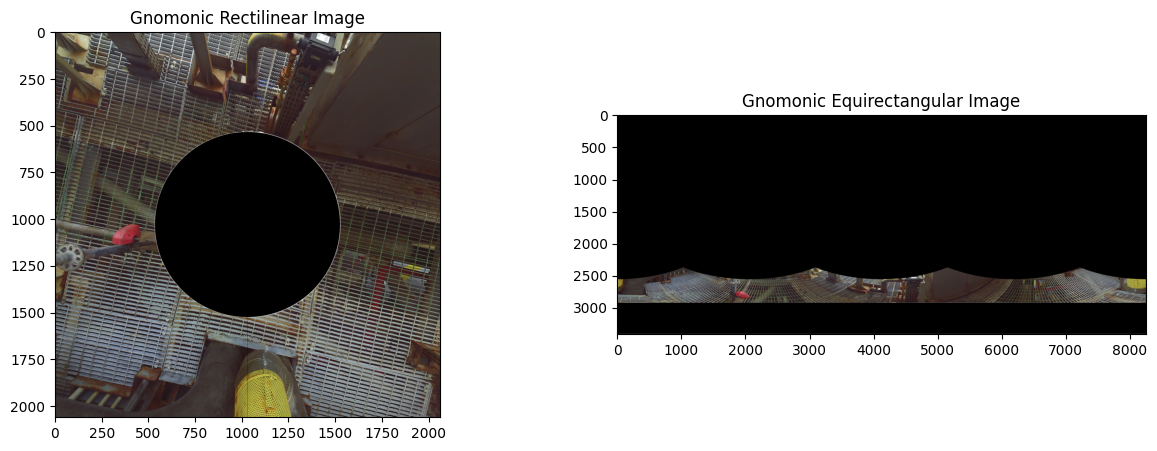

In [1]:
import numpy as np
import cv2
from projection.registry import ProjectionRegistry
import matplotlib.pyplot as plt

def test_gnomonic_projection(image_path: str, output_dir: str,**kwargs):
    """
    Test the Gnomonic projection system by performing forward and backward projections.

    Args:
        image_path (str): Path to the input equirectangular image.
        output_dir (str): Directory to save the output images.
    """
    # Step 1: Load the equirectangular image
    equirect_img = cv2.imread(image_path)
    if equirect_img is None:
        raise RuntimeError(f"Failed to load the image at {image_path}.")
    H, W, _ = equirect_img.shape

    # Convert the image from BGR to RGB
    equirect_img = cv2.cvtColor(equirect_img, cv2.COLOR_BGR2RGB)

    # Step 2: Retrieve and instantiate a Gnomonic projection processor
    processor = ProjectionRegistry.get_projection(
        "gnomonic",
        return_processor=True,
        phi1_deg=-90,
        lam0_deg=0,
        lat_points=H,
        lon_points=W,
        x_points=W//4 ,
        y_points=W//4,
        fov_deg=90
    )

    # Step 3: Perform forward projection to rectilinear
    rectilinear_img = processor.forward(equirect_img, **kwargs)
    rectilinear_path = f"{output_dir}/gnomonic_rectilinear.png"
    cv2.imwrite(rectilinear_path, cv2.cvtColor(rectilinear_img, cv2.COLOR_RGB2BGR))
    print(f"Gnomonic Rectilinear image saved to {rectilinear_path}")

    # Step 4: Perform backward projection to equirectangular
    equirectangular_img = processor.backward(
        rectilinear_img,
        return_mask=True,
        #**kwargs
    )
    equirectangular_path = f"{output_dir}/gnomonic_equirectangular.png"
    cv2.imwrite(equirectangular_path, cv2.cvtColor(equirectangular_img, cv2.COLOR_RGB2BGR))
    print(f"Gnomonic Equirectangular image saved to {equirectangular_path}")

    # Step 5: Mask pixels outside the projection area
    mask = np.mean(equirectangular_img, axis=-1) > 0

    # Step 6: Compute the Mean Absolute Error (MAE)
    mae_img = np.abs(equirect_img * mask[:, :, None] - equirectangular_img)
    mae = np.mean(mae_img[mask])
    print(f"Gnomonic Projection Mean Absolute Error: {mae}")

    # Step 7: Visualize the results
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    plt.title("Gnomonic Rectilinear Image")
    plt.imshow(rectilinear_img)

    plt.subplot(1, 2, 2)
    plt.title("Gnomonic Equirectangular Image")
    plt.imshow(equirectangular_img)

    plt.show()

kwargs = {
    'delta_lon': 0,
    'delta_lat': 0,
    'fov_extra': 30,
}
file = "data/image1.png"
file = "data/eq_sample.png"
test_gnomonic_projection(image_path=file, output_dir="results",**kwargs)

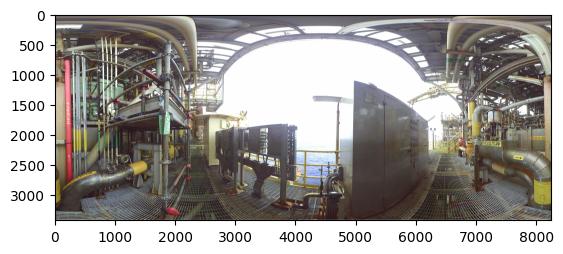

2025-01-13 16:40:21,546 - gnomonic_projection.base.interpolation - INFO - BaseInterpolation initialized successfully.
2025-01-13 16:40:21,547 - gnomonic_projection.processor - INFO - ProjectionProcessor components initialized successfully.
2025-01-13 16:40:23,246 - gnomonic_projection.base.interpolation - INFO - Image interpolation completed successfully.
2025-01-13 16:40:23,250 - gnomonic_projection.processor - INFO - Forward projection completed successfully.
Mercator Rectilinear image saved to results/mercator_rectilinear.png
2025-01-13 16:40:23,744 - gnomonic_projection.base.interpolation - INFO - Image interpolation completed successfully.
2025-01-13 16:40:23,748 - gnomonic_projection.processor - INFO - Backward projection completed successfully.
Mercator Equirectangular image saved to results/mercator_equirectangular.png
Mercator Projection Mean Absolute Error: 120.22444841780536
255


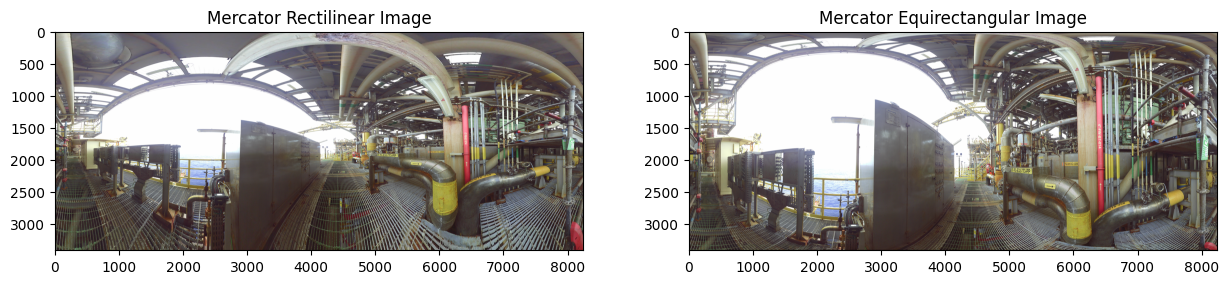

In [2]:
import numpy as np
import cv2
from projection.registry import ProjectionRegistry
import matplotlib.pyplot as plt

def test_mercator_projection(image_path: str, output_dir: str,**kwargs):
    """
    Test the Mercator projection system by performing forward and backward projections.

    Args:
        image_path (str): Path to the input equirectangular image.
        output_dir (str): Directory to save the output images.
    """
    # Step 1: Load the equirectangular image
    equirect_img = cv2.imread(image_path)
    if equirect_img is None:
        raise RuntimeError(f"Failed to load the image at {image_path}.")
    H, W, _ = equirect_img.shape

    # Convert the image from BGR to RGB
    equirect_img = cv2.cvtColor(equirect_img, cv2.COLOR_BGR2RGB)
    plt.imshow(equirect_img)
    plt.show()

    # Step 2: Retrieve and instantiate a Mercator projection processor
    processor = ProjectionRegistry.get_projection(
        "mercator",
        return_processor=True,
        R=1,  # Earth's radius in kilometers
        lon_min=-180,
        lon_max=180,
        lat_min=-85,
        lat_max=85,
        x_points=W,
        y_points=H
    )

    # Step 3: Perform forward projection to rectilinear
    rectilinear_img = processor.forward(equirect_img,**kwargs)
    rectilinear_path = f"{output_dir}/mercator_rectilinear.png"
    cv2.imwrite(rectilinear_path, cv2.cvtColor(rectilinear_img, cv2.COLOR_RGB2BGR))
    print(f"Mercator Rectilinear image saved to {rectilinear_path}")

    # Step 4: Perform backward projection to equirectangular
    equirectangular_img = processor.backward(
        rectilinear_img,
        return_mask=True,
        **kwargs
    )
    equirectangular_path = f"{output_dir}/mercator_equirectangular.png"
    cv2.imwrite(equirectangular_path, cv2.cvtColor(equirectangular_img, cv2.COLOR_RGB2BGR))
    print(f"Mercator Equirectangular image saved to {equirectangular_path}")

    # Step 5: Mask pixels outside the projection area
    mask = np.mean(equirectangular_img, axis=-1) > 0

    # Step 6: Compute the Mean Absolute Error (MAE)
    mae_img = np.abs(equirect_img * mask[:, :, None] - equirectangular_img)
    mae = np.mean(mae_img[mask])
    print(f"Mercator Projection Mean Absolute Error: {mae}")

    # Step 7: Visualize the results
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    plt.title("Mercator Rectilinear Image")
    plt.imshow(rectilinear_img)
    print(rectilinear_img.max())

    plt.subplot(1, 2, 2)
    plt.title("Mercator Equirectangular Image")
    plt.imshow(equirectangular_img)

    plt.show()
    return rectilinear_img, equirectangular_img, mask


kwargs = {
    'delta_lon': 90,
    'delta_lat': 0,
    'fov_extra': 29.8,
}
file = "data/image1.png"
file = "data/eq_sample.png"

rectilinear_img , equirectangular_img, mask = test_mercator_projection(image_path=file, output_dir="results", **kwargs)

